In [1]:
import math
import pickle
from collections import defaultdict

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
from Cenario.GeradorDeCenarios import Cenario, GeradorDeCenarios
from registrador import Registrador
from Roteamento.Roteamento_evitando_nodes_pre_desastre import (
    Roteamento_evitando_nodes_pre_desastre,
)
from Roteamento.roteamento_subrede import (
    RoteamentoSubrede,
)
from simpy import Environment
from variaveis import *

from simulador import Simulador

TOPOLOGY = nx.read_weighted_edgelist("../topology/usa", nodetype=int)

### Encontra bons pontos de desastre para topologia

In [2]:
def __find_balanced_min_cut(graph: nx.Graph):
    def __recover_partition_data(partition, graph: nx.Graph):
        reachable, non_reachable = partition
        cut_edges = [
            (u, v)
            for u, v in graph.edges()
            if (u in reachable and v in non_reachable)
            or (v in reachable and u in non_reachable)
        ]
        return {
            "partition_1": reachable
            if len(reachable) < len(non_reachable)
            else non_reachable,
            "partition_2": non_reachable
            if len(reachable) < len(non_reachable)
            else reachable,
            "cut_edges": cut_edges,
        }

    # Set default capacities if missing
    for u, v in graph.edges():
        if "capacity" not in graph[u][v]:
            graph[u][v]["capacity"] = 1  # Default capacity for unweighted edges

    best_cut_value = float("inf")
    best_size_difference = float("inf")
    best_partitions_set = set()  # To store unique partitions
    # Iterate over all pairs of nodes as source (s) and sink (t)
    for s in graph.nodes():
        for t in graph.nodes():
            if s == t:
                continue

            # Skip pairs where there is no path
            if not nx.has_path(graph, s, t):
                continue

            try:
                # Calculate the minimum cut between s and t
                cut_value, partition = nx.minimum_cut(graph, s, t)
                (reachable, non_reachable) = partition

                # Ensure balance between the two partitions
                size_difference = abs(len(reachable) - len(non_reachable))

                # Create a frozenset to compare unique partitions
                partition_frozen = frozenset(
                    (frozenset(reachable), frozenset(non_reachable))
                )

                if cut_value < best_cut_value or (
                    cut_value == best_cut_value
                    and size_difference < best_size_difference
                ):
                    best_cut_value = cut_value
                    best_size_difference = size_difference
                    best_partitions_set = {
                        partition_frozen
                    }  # Reset to only this partition

                elif (
                    cut_value == best_cut_value
                    and size_difference == best_size_difference
                ):
                    best_partitions_set.add(partition_frozen)  # Add only if unique

            except nx.NetworkXUnbounded:
                print(
                    f"Unbounded flow for source {s} and sink {t}, skipping this pair."
                )

    # Create list of partition data

    results = []
    for partition in best_partitions_set:
        partition_data = __recover_partition_data(partition, graph)
        results.append(partition_data)

    return {
        "partitions": results,
        "min_cut_value": best_cut_value,
        "min_size_difference": best_size_difference,
    }


def __remove_node_from_graph(graph: nx.Graph, nodes: list[int]):
    graph = graph.copy()
    graph.remove_nodes_from(nodes)
    return graph


def __find_balanced_min_cut_for_all_nodes():
    original_graph = TOPOLOGY
    dados = []
    for node in original_graph.nodes():
        copy_graph = __remove_node_from_graph(original_graph, [node])
        dado = __find_balanced_min_cut(copy_graph)
        dado["node"] = node
        dados.append(dado)
    dados.sort(key=lambda x: x["min_size_difference"])
    return dados


def print_balanced_min_cut_for_all_nodes():
    for dado in __find_balanced_min_cut_for_all_nodes():
        if dado["min_size_difference"] == 21:
            continue
        print(
            f"Node {dado['node']} removido, corte minimo = {dado['min_cut_value']}, diferença de tamanho minima = {dado['min_size_difference']}"
        )
        for particao in dado["partitions"]:
            print(
                f"Arestas de corte {particao['cut_edges']},\n Partição 1: {list(particao['partition_1'])}, Partição 2: {list(particao['partition_2'])}"
            )
        print("\n\n")


__info_pior_desastre = __find_balanced_min_cut_for_all_nodes()[0]
NODE_DESASTRE = __info_pior_desastre["node"]
COMPONENTE_1 = __info_pior_desastre["partitions"][0]["partition_1"]
COMPONENTE_2 = __info_pior_desastre["partitions"][0]["partition_2"]
CRITICAL_EDGES = __info_pior_desastre["partitions"][0]["cut_edges"]

### Cria cenario

In [3]:
criar_e_rodar_novo_cenario = True
is_logger_active = True

In [4]:
env = Environment()


if criar_e_rodar_novo_cenario:
    roteamentos_a_serem_testados = [
        RoteamentoSubrede,
        Roteamento_evitando_nodes_pre_desastre,
    ]

    cenario1, cenario2 = GeradorDeCenarios.gerar_cenarios(
        TOPOLOGY,
        retorna_lista_de_requisicoes=True,
        numero_de_requisicoes=NUMERO_DE_REQUISICOES,
        lista_de_roteamentos_de_desastre=roteamentos_a_serem_testados,
        disaster_node=NODE_DESASTRE,
    )

    # salvar cenarios
    with open("cenario/cenarios/cenario1.pkl", "wb") as file:
        pickle.dump(cenario1, file)

    with open("cenario/cenarios/cenario2.pkl", "wb") as file:
        pickle.dump(cenario2, file)

# carregar cenarios
cenario1: Cenario = pickle.load(open("cenario/cenarios/cenario1.pkl", "rb"))
cenario2: Cenario = pickle.load(open("cenario/cenarios/cenario2.pkl", "rb"))

Link  9 11  vai falhar
Link  9 7  vai falhar
Link  9 10  vai falhar
Link  9 6  vai falhar
Link  9 7  vai falhar
Link  9 10  vai falhar
Link  9 11  vai falhar
Link  9 12  vai falhar
node_desastre 9


### Roda cenarios

In [5]:
cenario1.desastre.list_of_dict_node_per_start_time

[{'tipo': 'node', 'node': 9, 'start_time': 52}]

In [6]:
if criar_e_rodar_novo_cenario:
    # roda cenario1
    Registrador.reseta_registrador()
    env = Environment()
    simulador: Simulador = Simulador(
        env=env, topology=TOPOLOGY, status_logger=is_logger_active, cenario=cenario1
    )
    simulador.run()
    dataframe_cenario1 = simulador.salvar_dataframe("_out/resultados/df_cenario1")
    dataframe_sliding_window = Registrador.cria_dataframe_janela_deslizante(
        "_out/dataset1"
    )
    dataframe_media_disponibilidade_extra_componente = (
        Registrador.cria_dataframe_media_taxa_de_disponibilidade_extra_componente(
            "_out/dataset1"
        )
    )
    dataframe_bloqueio_artificial = Registrador.cria_dataframe_bloqueio_artificial(
        "_out/dataset1"
    )

    # roda cenario2
    env = Environment()
    Registrador.reseta_registrador()
    simulador: Simulador = Simulador(
        env=env, topology=TOPOLOGY, status_logger=is_logger_active, cenario=cenario2
    )
    simulador.run()
    dataframe2_sliding_window = Registrador.cria_dataframe_janela_deslizante(
        "_out/dataset2"
    )
    dataframe2_media_disponibilidade_extra_componente = (
        Registrador.cria_dataframe_media_taxa_de_disponibilidade_extra_componente(
            "_out/dataset2"
        )
    )
    dataframe_cenario2 = simulador.salvar_dataframe("_out/resultados/df_cenario2")
    dataframe2_bloqueio_artificial = Registrador.cria_dataframe_bloqueio_artificial(
        "_out/dataframe2"
    )


dataframe1: pd.DataFrame = pd.read_csv("_out/resultados/df_cenario1.csv")
dataframe2: pd.DataFrame = pd.read_csv("_out/resultados/df_cenario2.csv")

TypeError: '>' not supported between instances of 'NoneType' and 'float'

In [ ]:
ACTION_START_TIME = {
    isp.isp_id: isp.datacenter.tempo_de_reacao for isp in cenario1.lista_de_isps
}
DISASTER_START_TIME = min(
    [(isp.datacenter.tempo_de_reacao, isp.isp_id) for isp in cenario1.lista_de_isps]
)[0]
DISASTER_END_TIME = cenario1.desastre.start + cenario1.desastre.duration

### Funções de calculo auxiliares

In [ ]:
def calculate_average_disponibility(dataframe):
    number_of_requests = len(dataframe)
    number_of_accepted_requests = len(dataframe[dataframe["bloqueada"] == False])
    return number_of_accepted_requests / number_of_requests


def __devolve_dict_distancia_minima_entre_nodes():
    dict_nodes_para_distancia_minima_entre_nodes = {}
    dict_distancia_minima_entre_nodes_para_nodes = defaultdict(list)
    for node1 in cenario1.topology.topology:
        for node2 in cenario1.topology.topology:
            if node1 == node2:
                continue

            menor_caminho = cenario1.topology.caminhos_mais_curtos_entre_links[node1][
                node2
            ][0]["caminho"]
            tamanho_menor_caminho = len(menor_caminho) - 1
            dict_nodes_para_distancia_minima_entre_nodes[(node1, node2)] = (
                tamanho_menor_caminho
            )
            dict_distancia_minima_entre_nodes_para_nodes[tamanho_menor_caminho].append(
                (node1, node2)
            )

    return dict_distancia_minima_entre_nodes_para_nodes


def __devolve_distancia_minima_entre_nodes(
    extra_componente: bool = True,
    intra_componente1: bool = False,
    intra_componente2: bool = False,
):
    if extra_componente:
        par_de_componentes = (COMPONENTE_1, COMPONENTE_2)
    if intra_componente1:
        par_de_componentes = (COMPONENTE_1, COMPONENTE_1)
    if intra_componente2:
        par_de_componentes = (COMPONENTE_2, COMPONENTE_2)

    distancia_minima_entre_nodes_para_nodes_extra_componente = defaultdict(list)
    for distancia, links in __devolve_dict_distancia_minima_entre_nodes().items():
        for link in links:
            if (
                link[0] in par_de_componentes[0] and link[1] in par_de_componentes[1]
            ) or (
                link[0] in par_de_componentes[1] and link[1] in par_de_componentes[0]
            ):
                distancia_minima_entre_nodes_para_nodes_extra_componente[
                    distancia
                ].append(link)
    return distancia_minima_entre_nodes_para_nodes_extra_componente


def __retorna_dict_numero_de_vizinhos_por_node():
    dict_node_numero_de_vizinhos = {}
    dict_numero_de_vizinhos_por_nodes = defaultdict(list)
    for node in cenario1.topology.topology:
        numero_de_vizinhos = len(list(cenario1.topology.topology.neighbors(node)))
        dict_node_numero_de_vizinhos[node] = numero_de_vizinhos
        dict_numero_de_vizinhos_por_nodes[numero_de_vizinhos].append(node)
    return dict_numero_de_vizinhos_por_nodes


def calculate_average_distance_between_groups_of_nodes(
    grupo_de_nodes_1, grupo_de_nodes_2
):
    distancia_media_entre_grupos = 0
    dict_nodes_para_distancia_minima_entre_nodes = (
        __devolve_dict_distancia_minima_entre_nodes()
    )

    for node1 in grupo_de_nodes_1:
        for node2 in grupo_de_nodes_2:
            distancia_media_entre_grupos += (
                dict_nodes_para_distancia_minima_entre_nodes[(node1, node2)]
            )
    distancia_media_entre_grupos /= len(grupo_de_nodes_1) * len(grupo_de_nodes_2)
    return distancia_media_entre_grupos


def retorna_dict_distacia_minima_entre_node_e_node_de_escape():
    nodes_de_escape = [
        CRITICAL_EDGES[0][0],
        CRITICAL_EDGES[0][1],
        CRITICAL_EDGES[1][0],
        CRITICAL_EDGES[1][1],
    ]
    dict_node_distancia_minima_entre_nodes_de_escape = defaultdict(int)

    for node in cenario1.topology.topology.nodes:
        if node == 9:
            continue
        if node in nodes_de_escape:
            dict_node_distancia_minima_entre_nodes_de_escape[node] = 0
            continue
        menor_distancia = float("inf")
        for node_de_escape in nodes_de_escape:
            menor_distancia = min(
                menor_distancia,
                len(
                    cenario1.topology.caminhos_mais_curtos_entre_links[node][
                        node_de_escape
                    ][0]["caminho"]
                )
                - 1,
            )

        dict_node_distancia_minima_entre_nodes_de_escape[node] = menor_distancia
    return dict_node_distancia_minima_entre_nodes_de_escape


def retorna_menor_numero_de_slots(node1, node2, bandwidth, tempo, isp):
    if ACTION_START_TIME[isp] > tempo:
        if node1 == NODE_DESASTRE or node2 == NODE_DESASTRE:
            return 0
        info = cenario1.topology.caminhos_mais_curtos_entre_links_durante_desastre[
            node1
        ][node2][0]
    else:
        info = cenario1.topology.caminhos_mais_curtos_entre_links[node1][node2][0]
    modulacao = info["fator_de_modulacao"]
    tamanho = len(info["caminho"]) - 1

    return math.ceil(bandwidth * tamanho / modulacao)

### Funcões de manipulação do dataframe de requisições

In [ ]:
def devolve_extra_component_para_node(node, dataframe):
    componente_oposto = COMPONENTE_1 if node in COMPONENTE_2 else COMPONENTE_2
    return dataframe[
        (dataframe["src"] == node) & (dataframe["dst"].isin(componente_oposto))
    ]


def devolve_dataframe_para_link(link, dataframe):
    return dataframe[(dataframe["src"] == link[0]) & (dataframe["dst"] == link[1])]


def devolve_dataframe_desastre(dataframe):
    first_migration_time = min(
        [(isp.datacenter.tempo_de_reacao, isp.isp_id) for isp in cenario1.lista_de_isps]
    )[0]
    desaster_end_time = cenario1.desastre.start + cenario1.desastre.duration

    return dataframe[
        (dataframe["tempo_criacao"] >= first_migration_time)
        & (dataframe["tempo_criacao"] <= desaster_end_time)
    ]


def devolve_dataframe_antes_do_desastre(dataframe):
    first_migration_time = min(
        [(isp.datacenter.tempo_de_reacao, isp.isp_id) for isp in cenario1.lista_de_isps]
    )[0]
    return dataframe[(dataframe["tempo_criacao"] <= first_migration_time)]


def devolve_dataframe_depois_do_desastre(dataframe):
    desaster_end_time = cenario1.desastre.start + cenario1.desastre.duration

    return dataframe[(dataframe["tempo_criacao"] >= desaster_end_time)]


def devolve_dataframe_apenas_extra_componente(dataframe):
    return dataframe[
        (dataframe["src"].isin(COMPONENTE_1)) & (dataframe["dst"].isin(COMPONENTE_2))
        | (dataframe["src"].isin(COMPONENTE_2)) & (dataframe["dst"].isin(COMPONENTE_1))
    ]


def devolve_dict_de_dataframes_distancia_entre_nodes_para_df(
    dataframe,
    extra_componente: bool = True,
    intra_componente1: bool = False,
    intra_componente2: bool = False,
):
    dataframe_desastre = devolve_dataframe_desastre(dataframe)

    dataframes_trafego_extra_componente_por_distancia = defaultdict(pd.DataFrame)
    for distancia, links in __devolve_distancia_minima_entre_nodes(
        extra_componente, intra_componente1, intra_componente2
    ).items():
        df = pd.DataFrame()
        for link in links:
            df = pd.concat([df, devolve_dataframe_para_link(link, dataframe_desastre)])
        df = df.sort_values("tempo_criacao")
        df.drop_duplicates()
        dataframes_trafego_extra_componente_por_distancia[distancia] = df
    return dataframes_trafego_extra_componente_por_distancia


def devolve_dict_de_dataframes_numero_de_vizinhos_para_df(dataframe: pd.DataFrame):
    dict_numero_de_vizinhos_por_nodes = __retorna_dict_numero_de_vizinhos_por_node()
    dict_dataframes_numero_de_vizinhos = defaultdict(pd.DataFrame)
    for numero_de_vizinhos, nodes in dict_numero_de_vizinhos_por_nodes.items():
        filtered_dataframe = dataframe[
            dataframe.apply(lambda row: row["src"] in nodes, axis=1)
        ]
        dict_dataframes_numero_de_vizinhos[numero_de_vizinhos] = filtered_dataframe
    return dict_dataframes_numero_de_vizinhos


def devolve_dict_de_dataframes_por_nodes(dataframe):
    dict_dataframes_por_nodes = defaultdict(pd.DataFrame)
    for node in cenario1.topology.topology.nodes:
        dict_dataframes_por_nodes[node] = devolve_extra_component_para_node(
            node, dataframe
        )
    return dict_dataframes_por_nodes


def devolve_dict_de_dataframes_por_numero_de_slots_minimos(dataframe):
    dataframe["min_slots"] = dataframe.apply(
        lambda row: retorna_menor_numero_de_slots(
            row["src"],
            row["dst"],
            row["bandwidth"],
            row["tempo_criacao"],
            row["src_isp_index"],
        ),
        axis=1,
    )
    return dataframe

In [ ]:
devolve_dict_de_dataframes_por_numero_de_slots_minimos(dataframe1)["min_slots"].unique()

array([  6,  16,   3,   0,  72,  24,  12,  48, 196, 168,  96,  60,  32,
       192,  40,  56, 128,  10, 120,  80, 144, 160,  28,   8, 112,   7,
       100,  42,  20,  64,   4,  19, 140,  18,  14,  84,  11,  36,  30,
        22,   5,   2, 224])

### Funções de retorno de Dados

In [ ]:
def retorna_dict_de_delta_disponibilidade_por_node(dataframe: pd.DataFrame):
    dict_de_delta_disponibilidade = {}
    for node in cenario1.topology.topology.nodes:
        if node == 9:
            continue
        dataframe_antes_do_desastre = devolve_dataframe_antes_do_desastre(dataframe)
        dataframe_durante_do_desastre = devolve_dataframe_desastre(dataframe)

        disponibilidade_antes = calculate_average_disponibility(
            devolve_extra_component_para_node(node, dataframe_antes_do_desastre)
        )
        disponibilidade_durante = calculate_average_disponibility(
            devolve_extra_component_para_node(node, dataframe_durante_do_desastre)
        )

        dict_de_delta_disponibilidade[node] = {
            "texto": f"node {node:02d}, delta disponibilidade {(disponibilidade_durante - disponibilidade_antes) * 100:.4f}%, razão {(disponibilidade_durante / disponibilidade_antes) * 100:.4f}%, "
            + f"disponibilidade antes {disponibilidade_antes * 100:.4f}%, disponibilidade durante {disponibilidade_durante * 100:.4f}%",
            "delta": (disponibilidade_durante - disponibilidade_antes) * 100,
            "razão": (disponibilidade_durante / disponibilidade_antes) * 100,
            "disponibilidade_antes": disponibilidade_antes,
            "disponibilidade_durante": disponibilidade_durante,
        }
    return dict_de_delta_disponibilidade


def retorna_dados_delta_e_razão_degradação(dataframe):
    dict_delta_bloqueios = retorna_dict_de_delta_disponibilidade_por_node(dataframe)

    delta_degradação = [value["delta"] for value in dict_delta_bloqueios.values()]
    razao_degradação = [value["razão"] for value in dict_delta_bloqueios.values()]
    min_delta = min(delta_degradação)
    max_delta = max(delta_degradação)
    min_razao = min(razao_degradação)
    max_razao = max(razao_degradação)
    variancia_delta = np.std(delta_degradação)
    media_delta = np.mean(delta_degradação)
    variancia_razao = np.std(razao_degradação)
    media_razao = np.mean(razao_degradação)
    return {
        "delta": {
            "max": max_delta,
            "min": min_delta,
            "desvio_padrao": variancia_delta,
            "media": media_delta,
        },
        "razão": {
            "max": max_razao,
            "min": min_razao,
            "desvio_padrao": variancia_razao,
            "media": media_razao,
        },
    }


def retorna_disponibilidade_antes_durante_e_apos_desastre(dataframe):
    disponibilidade_antes = calculate_average_disponibility(
        devolve_dataframe_antes_do_desastre(
            devolve_dataframe_apenas_extra_componente(dataframe)
        )
    )
    disponibilidade_durante = calculate_average_disponibility(
        devolve_dataframe_desastre(devolve_dataframe_apenas_extra_componente(dataframe))
    )
    disponibilidade_apos = calculate_average_disponibility(
        devolve_dataframe_depois_do_desastre(
            devolve_dataframe_apenas_extra_componente(dataframe)
        )
    )

    return disponibilidade_antes, disponibilidade_durante, disponibilidade_apos


def retorna_disponibilidade_por_distancia_minima_entre_nodes(
    dataframe,
    extra_componente: bool = True,
    intra_componente1: bool = False,
    intra_componente2: bool = False,
):
    dict_dataframe = devolve_dict_de_dataframes_distancia_entre_nodes_para_df(
        dataframe, extra_componente, intra_componente1, intra_componente2
    )
    for distancia, dataframe in dict_dataframe.items():
        dict_dataframe[distancia] = calculate_average_disponibility(dataframe)
    return dict_dataframe


def retorna_desvio_padrao_disponibilidade_por_distancia(dataframe):
    dict_dataframe = __devolve_distancia_minima_entre_nodes()
    for distancia, dataframe in dict_dataframe.items():
        dict_dataframe[distancia] = np.std(dataframe)
    return dict_dataframe


def get_number_of_slots_alocated_during_disaster(dataframe):
    filtered_dataframe = dataframe[
        (dataframe["bloqueada"] == False)
        & (dataframe["tempo_criacao"] >= DISASTER_START_TIME)
        & (dataframe["tempo_desalocacao"] <= DISASTER_END_TIME)
    ].copy()

    filtered_dataframe["slots_used"] = (
        filtered_dataframe["numero_de_slots"] * filtered_dataframe["tamanho_do_caminho"]
    )

    return filtered_dataframe["slots_used"].sum()

In [ ]:
def teste(dataframe):
    dataframe_antes_do_desastre = devolve_dataframe_antes_do_desastre(dataframe)
    dataframe_desastre = devolve_dataframe_desastre(dataframe)
    dict_distancia_lista_de_disponibilidades_por_links_ = {}
    for (
        distancia,
        list_of_pair_of_nodes,
    ) in __devolve_distancia_minima_entre_nodes().items():
        lista_final = []
        for pair_of_nodes in list_of_pair_of_nodes:
            disponibilidade_antes = calculate_average_disponibility(
                devolve_dataframe_para_link(pair_of_nodes, dataframe_antes_do_desastre)
            )
            disponibilidade_durante = calculate_average_disponibility(
                devolve_dataframe_para_link(pair_of_nodes, dataframe_desastre)
            )
            lista_final.append(disponibilidade_durante - disponibilidade_antes)
        dict_distancia_lista_de_disponibilidades_por_links_[distancia] = float(
            np.std(lista_final)
        )
    return dict_distancia_lista_de_disponibilidades_por_links_


teste(dataframe2)

{1: 0.03167791137665803,
 2: 0.11882668794549354,
 3: 0.08682740319989109,
 4: 0.09946602320677278,
 5: 0.10417886546626852,
 6: 0.09406676352810685,
 7: 0.027071017719935905}

In [ ]:
retorna_disponibilidade_por_distancia_minima_entre_nodes(dataframe1, False, False, True)

defaultdict(pandas.core.frame.DataFrame,
            {1: 0.9990732159406858,
             2: 0.9654311251314406,
             3: 0.8569549490299244,
             4: 0.752724795640327,
             5: 0.6854838709677419,
             6: 0.7063829787234043})

### Funções de mostrar dados

In [ ]:
def print_average_disponibility_during_disaster(dataframe1, dataframe2):
    dataframe1_desastre_cross_component = devolve_dataframe_apenas_extra_componente(
        devolve_dataframe_desastre(dataframe1)
    )

    dataframe2_desastre_cross_component = devolve_dataframe_apenas_extra_componente(
        devolve_dataframe_desastre(dataframe2)
    )

    disponibilidade_media_dataframe1 = calculate_average_disponibility(
        dataframe1_desastre_cross_component
    )
    disponibilidade_media_dataframe2 = calculate_average_disponibility(
        dataframe2_desastre_cross_component
    )

    print(
        f"Disponibilidade media durante o desastre dataframe1: {disponibilidade_media_dataframe1 * 100:.2f}%"
    )
    print(
        f"Disponibilidade media durante o desastre dataframe2: {disponibilidade_media_dataframe2 * 100:.2f}%"
    )

    for node in range(1, 25):
        if node == 9:
            continue
        disponibilidade_media_node_dataframe1 = calculate_average_disponibility(
            devolve_extra_component_para_node(node, dataframe1_desastre_cross_component)
        )
        disponibilidade_media_node_dataframe2 = calculate_average_disponibility(
            devolve_extra_component_para_node(node, dataframe2_desastre_cross_component)
        )

        print(
            f"----------node {node} diferença de disponibilidade {(disponibilidade_media_node_dataframe1 - disponibilidade_media_node_dataframe2) * 100:.2f}%------------------"
        )
        print(
            f"Disponibilidade media durante o desastre node {node} dataframe1: {disponibilidade_media_node_dataframe1 * 100:.2f}%"
        )
        print(
            f"Disponibilidade media durante o desastre node {node} dataframe2: {disponibilidade_media_node_dataframe2 * 100:.2f}%"
        )


def print_average_disponibility_during_disaster_por_distancia(dataframe1, dataframe2):
    dataframe1_desastre_cross_component_by_distance = (
        devolve_dict_de_dataframes_distancia_entre_nodes_para_df(dataframe1)
    )
    dataframe2_desastre_cross_component_by_distance = (
        devolve_dict_de_dataframes_distancia_entre_nodes_para_df(dataframe2)
    )

    for distance in dataframe1_desastre_cross_component_by_distance.keys():
        disponibilidade_media_disastre_dataframe1 = calculate_average_disponibility(
            dataframe1_desastre_cross_component_by_distance[distance]
        )
        disponibilidade_media_disastre_dataframe2 = calculate_average_disponibility(
            dataframe2_desastre_cross_component_by_distance[distance]
        )

        print(
            f"----------distancia {distance} diferença de disponibilidade {(disponibilidade_media_disastre_dataframe1 - disponibilidade_media_disastre_dataframe2) * 100:.2f}%------------------"
        )

        print(
            f"disponibilidade media do desastre para distancia {distance}: {disponibilidade_media_disastre_dataframe1 * 100:.2f}%"
        )
        print(
            f"disponibilidade media do desastre para distancia {distance}: {disponibilidade_media_disastre_dataframe2 * 100:.2f}%"
        )


def print_average_distance_between_components():
    distancia_media_entre_componentes_1_2 = (
        calculate_average_distance_between_groups_of_nodes(COMPONENTE_1, COMPONENTE_2)
    )
    distancia_media_entre_componentes_1_1 = (
        calculate_average_distance_between_groups_of_nodes(COMPONENTE_1, COMPONENTE_1)
    )
    distancia_media_entre_componentes_2_2 = (
        calculate_average_distance_between_groups_of_nodes(COMPONENTE_2, COMPONENTE_2)
    )
    print(
        f"distancia media entre componentes 1 e 2: {distancia_media_entre_componentes_1_2}"
    )
    print(
        f"distancia media entre componentes 1 e 1: {distancia_media_entre_componentes_1_1}"
    )
    print(
        f"distancia media entre componentes 2 e 2: {distancia_media_entre_componentes_2_2}"
    )


def print_delta_disponibilidade_por_node():
    for value in retorna_dict_de_delta_disponibilidade_por_node().values():
        print(value["texto"])


def print_dados_delta_e_razão_degradação(dataframe):
    dados = retorna_dados_delta_e_razão_degradação(dataframe)
    max_delta = dados["delta"]["max"]
    min_delta = dados["delta"]["min"]
    variancia_delta = dados["delta"]["variancia"]
    media_delta = dados["delta"]["media"]
    max_razao = dados["razão"]["max"]
    min_razao = dados["razão"]["min"]
    variancia_razao = dados["razão"]["variancia"]
    media_razao = dados["razão"]["media"]
    print(
        f"maximo delta degradação {max_delta:.4f}%, minimum delta degradação {min_delta:.4f}%, variancia {variancia_delta:.4f}, media {media_delta:.4f}"
    )
    print(
        f"maximo razão degradação {max_razao:.4f}%, minimum razão degradação {min_razao:.4f}%, variancia {variancia_razao:.4f}, media {media_razao:.4f}"
    )

In [ ]:
def create_traffic_dataframes(dataframe1, dataframe2):
    """
    Creates separate dataframes for different types of traffic
    """
    # cross component traffic
    cross_component_df = devolve_dataframe_apenas_extra_componente(dataframe1)

    cross_component_df2 = devolve_dataframe_apenas_extra_componente(dataframe2)

    cross_component_node_10_df1 = devolve_extra_component_para_node(10, dataframe1)

    cross_component_node_10_df2 = devolve_extra_component_para_node(10, dataframe2)

    cross_component_node_24_df1 = devolve_extra_component_para_node(24, dataframe1)

    cross_component_node_24_df2 = devolve_extra_component_para_node(24, dataframe2)

    return {
        "Cross Component df1": cross_component_df,
        "Cross Component df2": cross_component_df2,
        "Cross Component Node 10": cross_component_node_10_df1,
        "Cross Component Node 10 2": cross_component_node_10_df2,
        "Cross Component Node 24": cross_component_node_24_df1,
        "Cross Component Node 24 2": cross_component_node_24_df2,
        #   "complete Dataset":original_df
    }


dataframes_dict = create_traffic_dataframes(dataframe1, dataframe2)

### Funções de plotagem

In [ ]:
def plota_migracao_e_desastre():
    # plota linhas verticais de inicio de migração
    tempos_de_inicio_migracao_ISP = [
        (isp.datacenter.tempo_de_reacao, isp.isp_id) for isp in cenario1.lista_de_isps
    ]

    for x in tempos_de_inicio_migracao_ISP:
        plt.axvline(x=x[0], color="red", linestyle="--", linewidth=1)

    # plota inicio e fim do desastre
    inicio_desastre = cenario1.desastre.start
    fim_desastre = cenario1.desastre.start + cenario1.desastre.duration

    plt.axvline(x=inicio_desastre, color="black", linestyle="--", linewidth=1)
    plt.axvline(x=fim_desastre, color="black", linestyle="--", linewidth=1)

In [ ]:
def plot_accumulated_blocked_requests(dataframes_dict):
    plt.figure(figsize=(18, 9), dpi=300)
    for key, dataframe in dataframes_dict.items():
        df = dataframe
        name = key

        # Total blocked requests
        df_blocked = df[df["bloqueada"] == True]

        df_accumulated = df_blocked.groupby("tempo_criacao").size().cumsum()
        plt.plot(
            df_accumulated.index, df_accumulated.values, label=f"{name} - Total Blocked"
        )

    # Plot migration and disaster lines
    plota_migracao_e_desastre()

    plt.xlabel("Segundos")
    plt.ylabel("Requisições Bloqueadas Acumuladas")
    plt.title("Requisições Bloqueadas Acumuladas por Segundo")
    plt.legend(loc="upper left")
    plt.grid(True)
    plt.show()


def plot_number_of_blocked_by_bucket(dataframe_dict, bucket_size=10):
    plt.figure(figsize=(18, 9), dpi=300)
    for name, dataframe in dataframe_dict.items():
        segundos = (dataframe["tempo_criacao"] // bucket_size) * bucket_size
        bloqueadas_por_segundo1 = (
            dataframe[dataframe["bloqueada"] == True].groupby(segundos).size()
        )
        plt.plot(
            bloqueadas_por_segundo1.index,
            bloqueadas_por_segundo1.values,
            label=f" {name} bloqueadas por {bucket_size} segundos",
        )
    plota_migracao_e_desastre()

    plt.xlabel("Segundos")
    plt.ylabel("Requisições Bloqueadas Acumuladas")
    plt.title("Requisições Bloqueadas Acumuladas por Segundo")

    plt.legend(loc="upper left")
    plt.grid(True)
    plt.show()


def plot_blocked_ratio_by_bucket(dataframe_dict, bucket_size=30):
    plt.figure(figsize=(18, 9), dpi=300)

    for name, dataframe in dataframe_dict.items():
        segundos = (dataframe["tempo_criacao"] // bucket_size) * bucket_size
        total_requisicoes_por_segundo1 = dataframe.groupby(segundos).size()
        bloqueadas_por_segundo1 = (
            dataframe[dataframe["bloqueada"] == True].groupby(segundos).size()
        )
        bloqueadas_por_segundo1 = bloqueadas_por_segundo1.reindex(
            total_requisicoes_por_segundo1.index, fill_value=0
        )
        proporcao_bloqueadas1 = bloqueadas_por_segundo1 / total_requisicoes_por_segundo1
        # plt.plot(proporcao_bloqueadas1.index, proporcao_bloqueadas1.values)
        plt.plot(
            proporcao_bloqueadas1.index,
            proporcao_bloqueadas1.values,
            label=f"{name} taxa de bloqueio por {bucket_size} segundos",
        )
    plota_migracao_e_desastre()

    plt.xlabel("Segundos")
    plt.ylabel("Proporção de Requisições Bloqueadas")
    plt.title(f"Proporção de Requisições Bloqueadas por {bucket_size} Segundo(s) ")
    plt.grid(True)
    plt.legend(loc="upper left")
    plt.show()


def plot_blocked_ratio_sliding_window(dataframes_dict, window_size=10):
    """
    Plot blocked ratio using a sliding window with improved smoothing

    Args:
        dataframes_dict (dict): Dictionary with names as keys and dataframes as values
        window_size (int): Size of the sliding window in seconds (default: 10)
    """
    plt.figure(figsize=(18, 9), dpi=300)

    for name, df in dataframes_dict.items():
        # Sort by time to ensure correct window calculations
        df = df.sort_values("tempo_criacao")

        # Create a more granular time series (e.g., 0.1 second intervals for smoother curve)
        all_times = np.arange(
            df["tempo_criacao"].min(), df["tempo_criacao"].max(), 0.1
        )  # 0.1 second steps

        # Calculate blocking ratio using rolling window
        ratios = []
        for time in all_times:
            window_df = df[
                (df["tempo_criacao"] >= time - window_size / 2)
                & (df["tempo_criacao"] < time + window_size / 2)
            ]

            if len(window_df) >= 5:  # Minimum sample size threshold
                ratio = window_df[
                    "bloqueada"
                ].mean()  # Using mean is equivalent to blocked/total
            else:
                # Use the last valid ratio or 0 if it's the start
                ratio = ratios[-1] if ratios else 0

            ratios.append(ratio)

        # Optional: Apply additional smoothing
        ratios = pd.Series(ratios).rolling(window=5, min_periods=1, center=True).mean()

        # Plot the results
        plt.plot(all_times, ratios, label=f"{name} (janela={window_size}s)")

    # Plot migration and disaster lines
    plota_migracao_e_desastre()

    plt.xlabel("Segundos")
    plt.ylabel("Taxa de Bloqueio")
    plt.title(f"Taxa de Bloqueio (Janela Deslizante de {window_size} segundos)")
    plt.grid(True)
    plt.legend(loc="upper left")
    plt.show()


def plot_avg_allocated_sum(
    link, dataframe, total_slots=200, time_step=0.1, window_size=10
):
    def __contem_link(caminho, link):
        for i in range(len(caminho) - 1):
            if (caminho[i], caminho[i + 1]) == link or (
                caminho[i + 1],
                caminho[i],
            ) == link:
                return True
        return False

    # Supondo que 'df' seja o seu DataFrame
    filtered_dataframe = dataframe[dataframe["bloqueada"] == False].copy()
    filtered_dataframe["caminho"] = filtered_dataframe["caminho"].apply(
        eval
    )  # Convertendo as strings para listas
    filtered_dataframe = filtered_dataframe[
        filtered_dataframe["caminho"].apply(lambda x: __contem_link(x, link))
    ]

    max_time = max(
        filtered_dataframe["tempo_desalocacao"].max(),
        filtered_dataframe["tempo_criacao"].max(),
    )

    # Initialize time points
    time_points = np.arange(10, max_time + time_step, time_step)

    # Store allocated_sum for each time step
    allocated_sums = []

    for t in time_points:
        # Filter the DataFrame for the current time
        current_requisitions = filtered_dataframe[
            (filtered_dataframe["tempo_criacao"] <= t)
            & (filtered_dataframe["tempo_desalocacao"] > t)
        ]

        # Initialize slots for the current time
        slots = np.zeros(total_slots, dtype=int)

        # Get allocated ranges and mark slots
        allocated_requests = current_requisitions["index_de_inicio_e_final"].tolist()
        allocated_requests = [eval(req) for req in allocated_requests]

        for start, end in allocated_requests:
            slots[start : end + 1] = 1  # +1 to include the last index

        # Calculate allocated_sum
        allocated_sum = np.sum(slots)
        allocated_sums.append(allocated_sum)

    # Calculate averages over the span of 10 seconds
    window_points = np.arange(0, max_time + time_step, time_step)
    avg_allocated_sums = []
    for t in window_points:
        # Define the window range
        start_time = max(0, t - window_size)
        end_time = t

        # Get indices within the window
        indices_in_window = (time_points >= start_time) & (time_points <= end_time)
        avg_allocated_sum = np.mean(np.array(allocated_sums)[indices_in_window])
        avg_allocated_sums.append(avg_allocated_sum)

    # Plot the results
    plota_migracao_e_desastre()
    plt.plot(
        window_points, avg_allocated_sums, label="Quantidade média de slots alocados"
    )
    plt.title(
        f"Quantidade media de Slots de frequência alocados no link {link} (janela de {window_size} segundos, dados do link coletados a cada {time_step} segundos)"
    )
    plt.xlabel("Tempo (segundos)")
    plt.ylabel("Media de Slots de Frequência Alocados")
    plt.grid(True)
    plt.legend()
    plt.show()


def plot_largest_free_window(
    link, dataframe=dataframe1, total_slots=200, time_step=0.1, window_size=10
):
    def __contem_link(caminho, link):
        for i in range(len(caminho) - 1):
            if (caminho[i], caminho[i + 1]) == link or (
                caminho[i + 1],
                caminho[i],
            ) == link:
                return True
        return False

    # Filter for non-blocked paths and containing the desired link
    filtered_dataframe = dataframe[dataframe["bloqueada"] == False].copy()
    filtered_dataframe["caminho"] = filtered_dataframe["caminho"].apply(
        eval
    )  # Convert strings to lists
    filtered_dataframe = filtered_dataframe[
        filtered_dataframe["caminho"].apply(lambda x: __contem_link(x, link))
    ]

    # Get the maximum time duration in the dataset
    max_time = max(
        filtered_dataframe["tempo_desalocacao"].max(),
        filtered_dataframe["tempo_criacao"].max(),
    )

    # Initialize time points
    time_points = np.arange(10, max_time + time_step, time_step)

    # Store the largest free window for each time step
    largest_windows = []

    for t in time_points:
        # Filter the DataFrame for the current time
        current_requisitions = filtered_dataframe[
            (filtered_dataframe["tempo_criacao"] <= t)
            & (filtered_dataframe["tempo_desalocacao"] > t)
        ]

        # Initialize slots for the current time
        slots = np.zeros(total_slots, dtype=int)

        # Get allocated ranges and mark slots
        allocated_requests = current_requisitions["index_de_inicio_e_final"].tolist()
        allocated_requests = [eval(req) for req in allocated_requests]

        for start, end in allocated_requests:
            slots[start : end + 1] = 1  # +1 to include the last index

        # Find the largest free window
        unallocated_windows = "".join(map(str, slots)).split("1")
        largest_window = max(len(window) for window in unallocated_windows)
        largest_windows.append(largest_window)

    # Calculate averages over the span of 10 seconds
    avg_largest_windows = []
    for t in time_points:
        # Define the window range
        start_time = max(0, t - window_size)
        end_time = t

        # Get indices within the window
        indices_in_window = (time_points >= start_time) & (time_points <= end_time)
        avg_largest_window = np.mean(np.array(largest_windows)[indices_in_window])
        avg_largest_windows.append(avg_largest_window)

    # Plot the results
    plota_migracao_e_desastre()
    plt.plot(
        time_points, avg_largest_windows, label="Tamanho medio da maior janela livre"
    )
    plt.title(
        f"Tamanho medio da maior janela livre pelo tempo no link {link} (janela de {window_size}, coletada cada {time_step} segundos)"
    )
    plt.xlabel("Tempo segundos")
    plt.ylabel("Tamanho medio da maior janela livre")
    plt.grid(True)
    plt.legend()
    plt.show()


def plot_network_usage(dataframe, time_step=0.1, window_size=10):
    # Filter for non-blocked paths and containing the desired link
    filtered_dataframe = dataframe[dataframe["bloqueada"] == False].copy()
    filtered_dataframe["slots_used"] = (
        filtered_dataframe["numero_de_slots"] * filtered_dataframe["tamanho_do_caminho"]
    )

    filtered_dataframe = filtered_dataframe[
        ["slots_used", "tempo_criacao", "tempo_desalocacao"]
    ]

    max_time = max(
        filtered_dataframe["tempo_desalocacao"].max(),
        filtered_dataframe["tempo_criacao"].max(),
    )
    numero_total_de_slots = len(TOPOLOGY.edges()) * NUMERO_DE_SLOTS
    time_points = np.arange(10, max_time + time_step, time_step)

    network_usage = []
    for t in time_points:
        current_requisitions = filtered_dataframe[
            (filtered_dataframe["tempo_criacao"] <= t)
            & (filtered_dataframe["tempo_desalocacao"] > t)
        ]
        network_usage.append(
            current_requisitions["slots_used"].sum() / numero_total_de_slots
        )

    # Calculate averages over 10-second windows
    window_points = np.arange(10, max_time + window_size, window_size)
    avg_network_usage = []
    for t in window_points:
        # Define the window range
        start_time = max(10, t - window_size)
        end_time = t

        # Get indices within the window
        indices_in_window = (time_points >= start_time) & (time_points <= end_time)
        avg_usage = np.mean(np.array(network_usage)[indices_in_window])
        avg_network_usage.append(avg_usage)

    plota_migracao_e_desastre()
    plt.plot(window_points, avg_network_usage, label="Uso médio de rede")
    plt.title("Porcentagem media de slots de frequência alocados na rede pelo tempo")
    plt.xlabel("Tempo segundos")
    plt.ylabel("Porcentagem media de slots de frequência alocados")
    plt.grid(True)
    plt.legend()
    plt.show()


def plot_network_usage_of_sub_networks(list_of_links, time_step=0.1, window_size=10):
    def teste(dataframe, list_of_links, label):
        def __contem_link(caminho):
            for i in range(len(caminho) - 1):
                if (caminho[i], caminho[i + 1]) in list_of_links or (
                    caminho[i + 1],
                    caminho[i],
                ) in list_of_links:
                    return True
            return False

        # Filter for non-blocked paths and containing the desired link
        filtered_dataframe = dataframe[dataframe["bloqueada"] == False].copy()
        filtered_dataframe["caminho"] = filtered_dataframe["caminho"].apply(
            eval
        )  # Convert strings to lists
        filtered_dataframe = filtered_dataframe[
            filtered_dataframe["caminho"].apply(lambda x: __contem_link(x))
        ]
        filtered_dataframe["slots_used"] = (
            filtered_dataframe["numero_de_slots"]
            * filtered_dataframe["tamanho_do_caminho"]
        )

        filtered_dataframe = filtered_dataframe[
            ["slots_used", "tempo_criacao", "tempo_desalocacao"]
        ]

        max_time = max(
            filtered_dataframe["tempo_desalocacao"].max(),
            filtered_dataframe["tempo_criacao"].max(),
        )
        numero_total_de_slots = len(list_of_links) * NUMERO_DE_SLOTS
        time_points = np.arange(10, max_time + time_step, time_step)

        network_usage = []
        for t in time_points:
            current_requisitions = filtered_dataframe[
                (filtered_dataframe["tempo_criacao"] <= t)
                & (filtered_dataframe["tempo_desalocacao"] > t)
            ]
            network_usage.append(
                current_requisitions["slots_used"].sum() / numero_total_de_slots
            )

        # Calculate averages over 10-second windows
        window_points = np.arange(10, max_time + window_size, window_size)
        avg_network_usage = []
        for t in window_points:
            # Define the window range
            start_time = max(10, t - window_size)
            end_time = t

            # Get indices within the window

            indices_in_window = (time_points >= start_time) & (time_points <= end_time)
            avg_usage = np.mean(np.array(network_usage)[indices_in_window])
            avg_network_usage.append(avg_usage)

        return window_points, avg_network_usage

    window_points_df1, avg_network_usage_df1 = teste(
        dataframe1, list_of_links, label="df1"
    )
    window_points_df2, avg_network_usage_df2 = teste(
        dataframe2, list_of_links, label="df2"
    )

    tempos_de_inicio_migracao_ISP = [
        (isp.datacenter.tempo_de_reacao, isp.isp_id) for isp in cenario1.lista_de_isps
    ]
    difference = [
        avg_network_usage_df1[i] - avg_network_usage_df2[i]
        for i in range(len(avg_network_usage_df1))
    ]

    for x in tempos_de_inicio_migracao_ISP:
        plt.axvline(x=x[0], color="red", linestyle="--", linewidth=1)

    # plota inicio e fim do desastre
    inicio_desastre = cenario1.desastre.start
    fim_desastre = cenario1.desastre.start + cenario1.desastre.duration

    difference_desastre = []
    for i in range(len(window_points_df1)):
        if (
            window_points_df1[i] > inicio_desastre
            and window_points_df1[i] < fim_desastre
        ):
            difference_desastre.append(difference[i])

    print(sum(difference_desastre) / len(difference_desastre))

    plt.plot(window_points_df1, difference, label="Diferença de uso de rede")
    plota_migracao_e_desastre()
    plt.title("Diferença de uso de rede entre df1 e df2")
    plt.xlabel("Tempo segundos")
    plt.ylabel("Porcentagem media de slots de frequência alocados")
    plt.grid(True)
    plt.legend()
    plt.show()

### Plotagem de Dados Finais

In [ ]:
def plot_disponibilidade_antes_durante_e_apos_desastre_bar_chart_para_dataframes():
    # Set figure size
    plt.figure(figsize=(12, 8))

    # Get data for both dataframes
    disponibilidade_antes_df1, disponibilidade_durante_df1, disponibilidade_apos_df1 = (
        retorna_disponibilidade_antes_durante_e_apos_desastre(dataframe1)
    )
    disponibilidade_antes_df2, disponibilidade_durante_df2, disponibilidade_apos_df2 = (
        retorna_disponibilidade_antes_durante_e_apos_desastre(dataframe2)
    )

    # Create positions for bars
    x = np.arange(3)
    width = 0.35  # Width of the bars

    # Create bars with offset
    plt.bar(
        x - width / 2,
        [
            disponibilidade_antes_df1,
            disponibilidade_durante_df1,
            disponibilidade_apos_df1,
        ],
        width,
        label="Bloqueio artificial",
        color="blue",
    )

    plt.bar(
        x + width / 2,
        [
            disponibilidade_antes_df2,
            disponibilidade_durante_df2,
            disponibilidade_apos_df2,
        ],
        width,
        label="Sem bloqueio artificial",
        color="orange",
    )

    # Customize the plot
    plt.xticks(x, ["Antes do Desastre", "Durante o Desastre", "Após o Desastre"])
    plt.ylabel("Disponibilidade")
    plt.legend()

    # Add grid for better readability
    plt.grid(True, axis="y", linestyle="--", alpha=0.7)

    plt.tight_layout()
    plt.show()


def plot_disponibilidade_por_distancia_minima_entre_nodes_bar_chart_para_dataframes_extra_componente():
    # Set figure size
    plt.figure(figsize=(12, 8))

    # Get data for both dataframes
    dict_dataframe1 = retorna_disponibilidade_por_distancia_minima_entre_nodes(
        dataframe1
    )
    dict_dataframe2 = retorna_disponibilidade_por_distancia_minima_entre_nodes(
        dataframe2
    )

    # Create positions for bars
    x = np.arange(len(dict_dataframe1))
    width = 0.35  # Width of the bars

    # Create bars with offset
    plt.bar(
        x - width / 2,
        [disponibilidade for disponibilidade in dict_dataframe1.values()],
        width,
        label="Bloqueio artificial",
        color="blue",
    )

    plt.bar(
        x + width / 2,
        [disponibilidade for disponibilidade in dict_dataframe2.values()],
        width,
        label="Sem bloqueio artificial",
        color="orange",
    )

    # Customize the plot
    plt.xticks(x, [f"{distancia}" for distancia in dict_dataframe1.keys()])
    plt.ylabel("Disponibilidade")
    plt.xlabel("distancia minima entre nodes")

    plt.legend()

    # Add grid for better readability
    plt.grid(True, axis="y", linestyle="--", alpha=0.7)

    plt.tight_layout()
    plt.show()


def plot_disponibilidade_por_distancia_minima_entre_nodes_bar_chart_para_dataframes_intra_componente1():
    # Set figure size
    plt.figure(figsize=(12, 8))

    # Get data for both dataframes
    dict_dataframe1 = retorna_disponibilidade_por_distancia_minima_entre_nodes(
        dataframe1, intra_componente1=True, extra_componente=False
    )
    dict_dataframe2 = retorna_disponibilidade_por_distancia_minima_entre_nodes(
        dataframe2, intra_componente1=True, extra_componente=False
    )

    # Create positions for bars
    x = np.arange(len(dict_dataframe1))
    width = 0.35  # Width of the bars

    # Create bars with offset
    plt.bar(
        x - width / 2,
        [disponibilidade for disponibilidade in dict_dataframe1.values()],
        width,
        label="Bloqueio artificial",
        color="blue",
    )

    plt.bar(
        x + width / 2,
        [disponibilidade for disponibilidade in dict_dataframe2.values()],
        width,
        label="Sem bloqueio artificial",
        color="orange",
    )

    # Customize the plot
    plt.xticks(x, [f"{distancia}" for distancia in dict_dataframe1.keys()])
    plt.ylabel("Disponibilidade")
    plt.xlabel("distancia minima entre nodes")

    plt.legend()

    # Add grid for better readability
    plt.grid(True, axis="y", linestyle="--", alpha=0.7)

    plt.tight_layout()
    plt.show()


def plot_disponibilidade_por_distancia_minima_entre_nodes_bar_chart_para_dataframes_intra_componente2():
    # Set figure size
    plt.figure(figsize=(12, 8))

    # Get data for both dataframes
    dict_dataframe1 = retorna_disponibilidade_por_distancia_minima_entre_nodes(
        dataframe1, intra_componente2=True, extra_componente=False
    )
    dict_dataframe2 = retorna_disponibilidade_por_distancia_minima_entre_nodes(
        dataframe2, intra_componente2=True, extra_componente=False
    )

    # Create positions for bars
    x = np.arange(len(dict_dataframe1))
    width = 0.35  # Width of the bars

    # Create bars with offset
    plt.bar(
        x - width / 2,
        [disponibilidade for disponibilidade in dict_dataframe1.values()],
        width,
        label="Bloqueio artificial",
        color="blue",
    )

    plt.bar(
        x + width / 2,
        [disponibilidade for disponibilidade in dict_dataframe2.values()],
        width,
        label="Sem bloqueio artificial",
        color="orange",
    )

    # Customize the plot
    plt.xticks(x, [f"{distancia}" for distancia in dict_dataframe1.keys()])
    plt.ylabel("Disponibilidade")
    plt.xlabel("distancia minima entre nodes")

    plt.legend()

    # Add grid for better readability
    plt.grid(True, axis="y", linestyle="--", alpha=0.7)

    plt.tight_layout()
    plt.show()


def plot_dados_delta_disponibilidade_para_dataframes():  # Set figure size
    plt.figure(figsize=(12, 8))

    # Get data for both dataframes
    dict_dataframe1 = retorna_dados_delta_e_razão_degradação(dataframe1)["delta"]
    dict_dataframe2 = retorna_dados_delta_e_razão_degradação(dataframe2)["delta"]

    # Create positions for bars
    x = np.arange(len(dict_dataframe1))
    width = 0.35  # Width of the bars

    # Create bars with offset
    plt.bar(
        x - width / 2,
        [value for value in dict_dataframe1.values()],
        width,
        label="Bloqueio artificial",
        color="blue",
    )

    plt.bar(
        x + width / 2,
        [value for value in dict_dataframe2.values()],
        width,
        label="Sem bloqueio artificial",
        color="orange",
    )

    # Customize the plot
    plt.xticks(x, [f"{distancia}" for distancia in dict_dataframe1.keys()])
    plt.ylabel("degradação de Disponibilidade")

    plt.legend()

    # Add grid for better readability
    plt.grid(True, axis="y", linestyle="--", alpha=0.7)

    plt.tight_layout()
    plt.show()


def plot_dados_razao_disponibilidade_para_dataframes():  # Set figure size
    plt.figure(figsize=(12, 8))

    # Get data for both dataframes
    dict_dataframe1 = retorna_dados_delta_e_razão_degradação(dataframe1)["razão"]
    dict_dataframe2 = retorna_dados_delta_e_razão_degradação(dataframe2)["razão"]

    # Create positions for bars
    x = np.arange(len(dict_dataframe1))
    width = 0.35  # Width of the bars

    # Create bars with offset
    plt.bar(
        x - width / 2,
        [value for value in dict_dataframe1.values()],
        width,
        label="Bloqueio artificial",
        color="blue",
    )

    plt.bar(
        x + width / 2,
        [value for value in dict_dataframe2.values()],
        width,
        label="Sem bloqueio artificial",
        color="orange",
    )

    # Customize the plot
    plt.xticks(x, [f"{distancia}" for distancia in dict_dataframe1.keys()])
    plt.ylabel("degradação de Disponibilidade")

    plt.legend()

    # Add grid for better readability
    plt.grid(True, axis="y", linestyle="--", alpha=0.7)

    plt.tight_layout()
    plt.show()


def plot_disponibilidade_por_nodes_bar_chart_para_dataframes():
    plt.figure(figsize=(16, 12))

    # Get data for both dataframes
    dict_dataframe1 = devolve_dict_de_dataframes_por_nodes(dataframe1)
    dict_final_1 = {}
    for node, dataframe in dict_dataframe1.items():
        if node != NODE_DESASTRE:
            antes, durante, depois = (
                retorna_disponibilidade_antes_durante_e_apos_desastre(dataframe)
            )
            dict_final_1[node] = {"antes": antes, "durante": durante, "depois": depois}

    dict_dataframe2 = devolve_dict_de_dataframes_por_nodes(dataframe2)
    dict_final_2 = {}
    for node, dataframe in dict_dataframe2.items():
        if node != NODE_DESASTRE:
            antes, durante, depois = (
                retorna_disponibilidade_antes_durante_e_apos_desastre(dataframe)
            )
            dict_final_2[node] = {"antes": antes, "durante": durante, "depois": depois}

    ordem = retorna_dict_distacia_minima_entre_node_e_node_de_escape()
    ordem = sorted(ordem.items(), key=lambda x: x[1])

    # Create positions for bars
    x = np.arange(len(dict_final_1))
    width = 0.2  # Width of the bars

    # Create bars with offset
    plt.bar(
        x - width / 2,
        [dict_final_1[node]["durante"] for node, _ in ordem],
        width,
        label="df1",
        color="blue",
    )

    plt.bar(
        x + width / 2,
        [dict_final_2[node]["durante"] for node, _ in ordem],
        width,
        label="df2",
        color="orange",
    )

    # Customize the plot
    plt.xticks(x, [f"{node}" for node, _ in ordem])
    plt.ylabel("Disponibilidade Durante o Desastre")
    plt.xlabel("Node")

    plt.legend()

    # Add grid for better readability
    plt.grid(True, axis="y", linestyle="--", alpha=0.7)

    plt.tight_layout()
    plt.show()


def plot_razao_disponibilidade_por_nodes_bar_chart_para_dataframes():
    plt.figure(figsize=(16, 12))

    # Get data for both dataframes
    dict_dataframe1 = retorna_dict_de_delta_disponibilidade_por_node(dataframe1)
    dict_final_1 = {}
    for node, dataframe in dict_dataframe1.items():
        if node != NODE_DESASTRE:
            dict_final_1[node] = dataframe["razão"]

    dict_dataframe2 = retorna_dict_de_delta_disponibilidade_por_node(dataframe2)
    dict_final_2 = {}
    for node, dataframe in dict_dataframe2.items():
        if node != NODE_DESASTRE:
            dict_final_2[node] = dataframe["razão"]

    # Create positions for bars
    x = np.arange(len(dict_final_1))
    width = 0.2  # Width of the bars

    ordered_dict_final_1 = sorted(dict_final_1.items(), key=lambda x: x[0])
    ordered_dict_final_2 = sorted(dict_final_2.items(), key=lambda x: x[0])
    # Create bars with offset
    plt.bar(
        x - width / 2,
        [value for _, value in ordered_dict_final_1],
        width,
        label="df1",
        color="blue",
    )

    plt.bar(
        x + width / 2,
        [value for _, value in ordered_dict_final_2],
        width,
        label="df2",
        color="orange",
    )

    # Customize the plot
    plt.xticks(x, [f"{node}" for node, value in ordered_dict_final_1])
    plt.ylabel("Razão de Degradação de Disponibilidade durante o desastre")
    plt.xlabel("Node")

    plt.legend()

    # Add grid for better readability
    plt.grid(True, axis="y", linestyle="--", alpha=0.7)

    plt.tight_layout()
    plt.show()


def plot_numero_de_slots_total_por_node_durante_desastre():
    plt.figure(figsize=(16, 12))

    # Get data for both dataframes
    dict_por_node_dataframe1 = devolve_dict_de_dataframes_por_nodes(dataframe1)
    dict_por_node_dataframe2 = devolve_dict_de_dataframes_por_nodes(dataframe2)

    for node, dataframe in dict_por_node_dataframe1.items():
        dict_por_node_dataframe1[node] = get_number_of_slots_alocated_during_disaster(
            dataframe
        )

    for node, dataframe in dict_por_node_dataframe2.items():
        dict_por_node_dataframe2[node] = get_number_of_slots_alocated_during_disaster(
            dataframe
        )

    # Create positions for bars
    x = np.arange(len(dict_por_node_dataframe1))
    width = 0.2  # Width of the bars

    ordered_dict_final_1 = sorted(dict_por_node_dataframe1.items(), key=lambda x: x[0])
    ordered_dict_final_2 = sorted(dict_por_node_dataframe2.items(), key=lambda x: x[0])
    # Create bars with offset
    plt.bar(
        x - width / 2,
        [value for _, value in ordered_dict_final_1],
        width,
        label="df1",
        color="blue",
    )

    plt.bar(
        x + width / 2,
        [value for _, value in ordered_dict_final_2],
        width,
        label="df2",
        color="orange",
    )

    # Customize the plot
    plt.xticks(x, [f"{node}" for node, value in ordered_dict_final_1])
    plt.ylabel("Razão de Degradação de Disponibilidade durante o desastre")
    plt.xlabel("Node")

    plt.legend()

    # Add grid for better readability
    plt.grid(True, axis="y", linestyle="--", alpha=0.7)

    plt.tight_layout()
    plt.show()

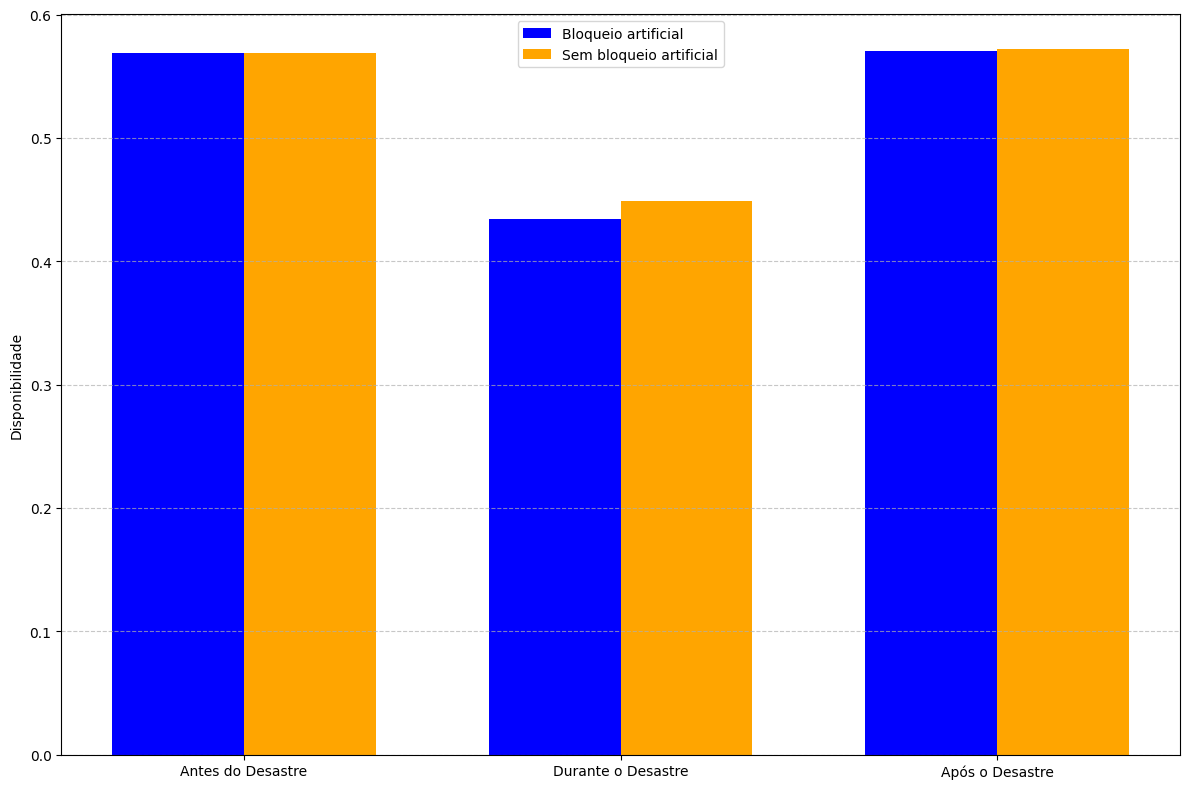

In [ ]:
plot_disponibilidade_antes_durante_e_apos_desastre_bar_chart_para_dataframes()

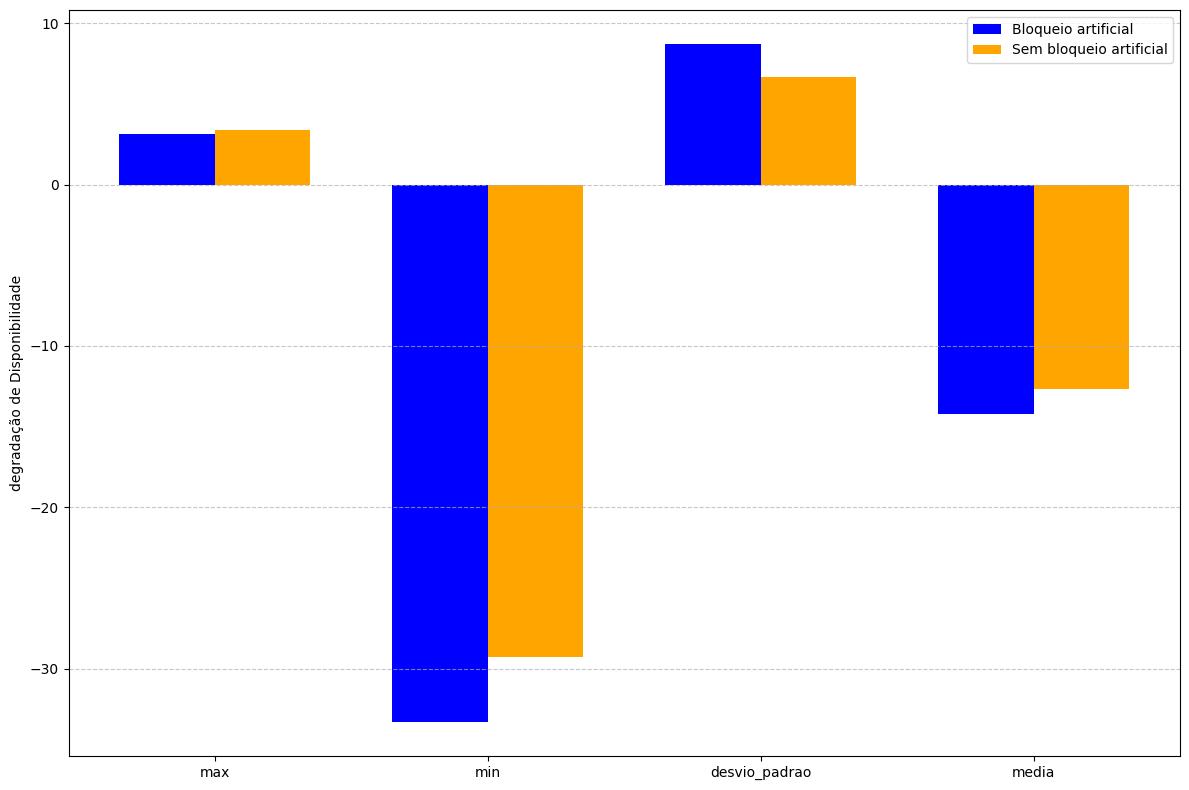

In [ ]:
plot_dados_delta_disponibilidade_para_dataframes()

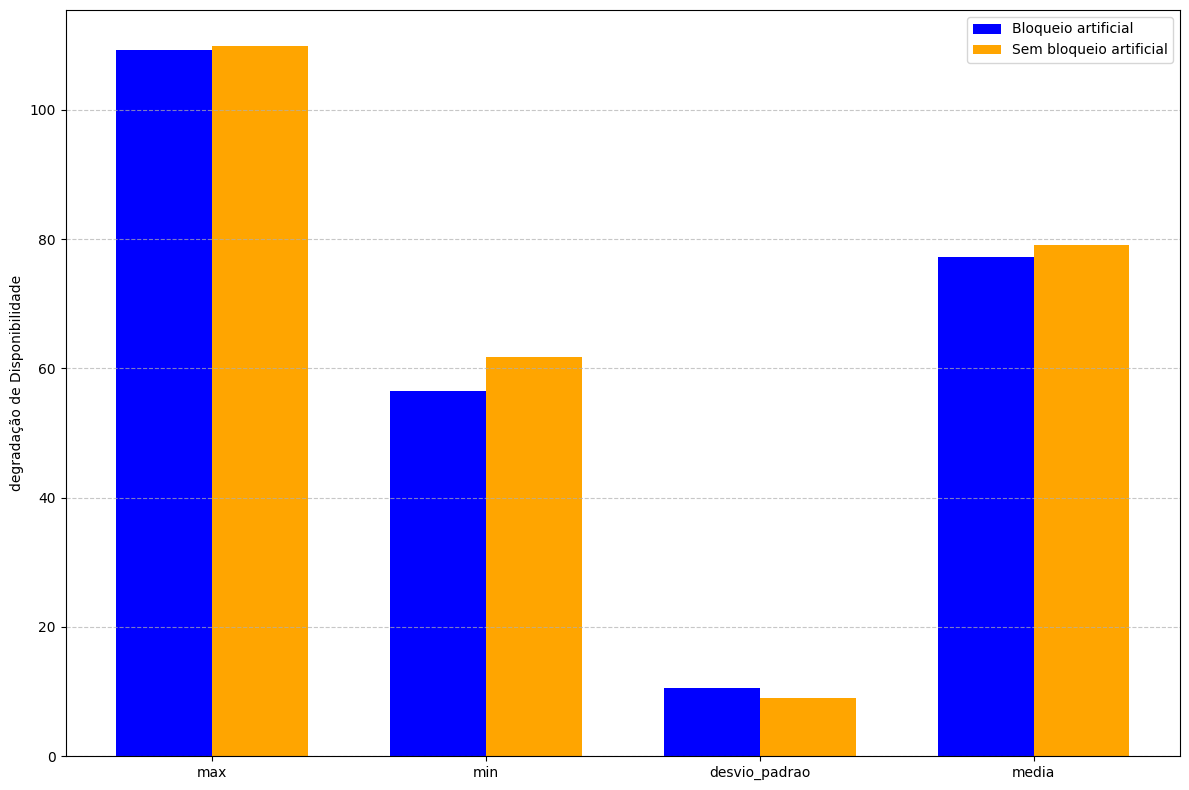

In [ ]:
plot_dados_razao_disponibilidade_para_dataframes()

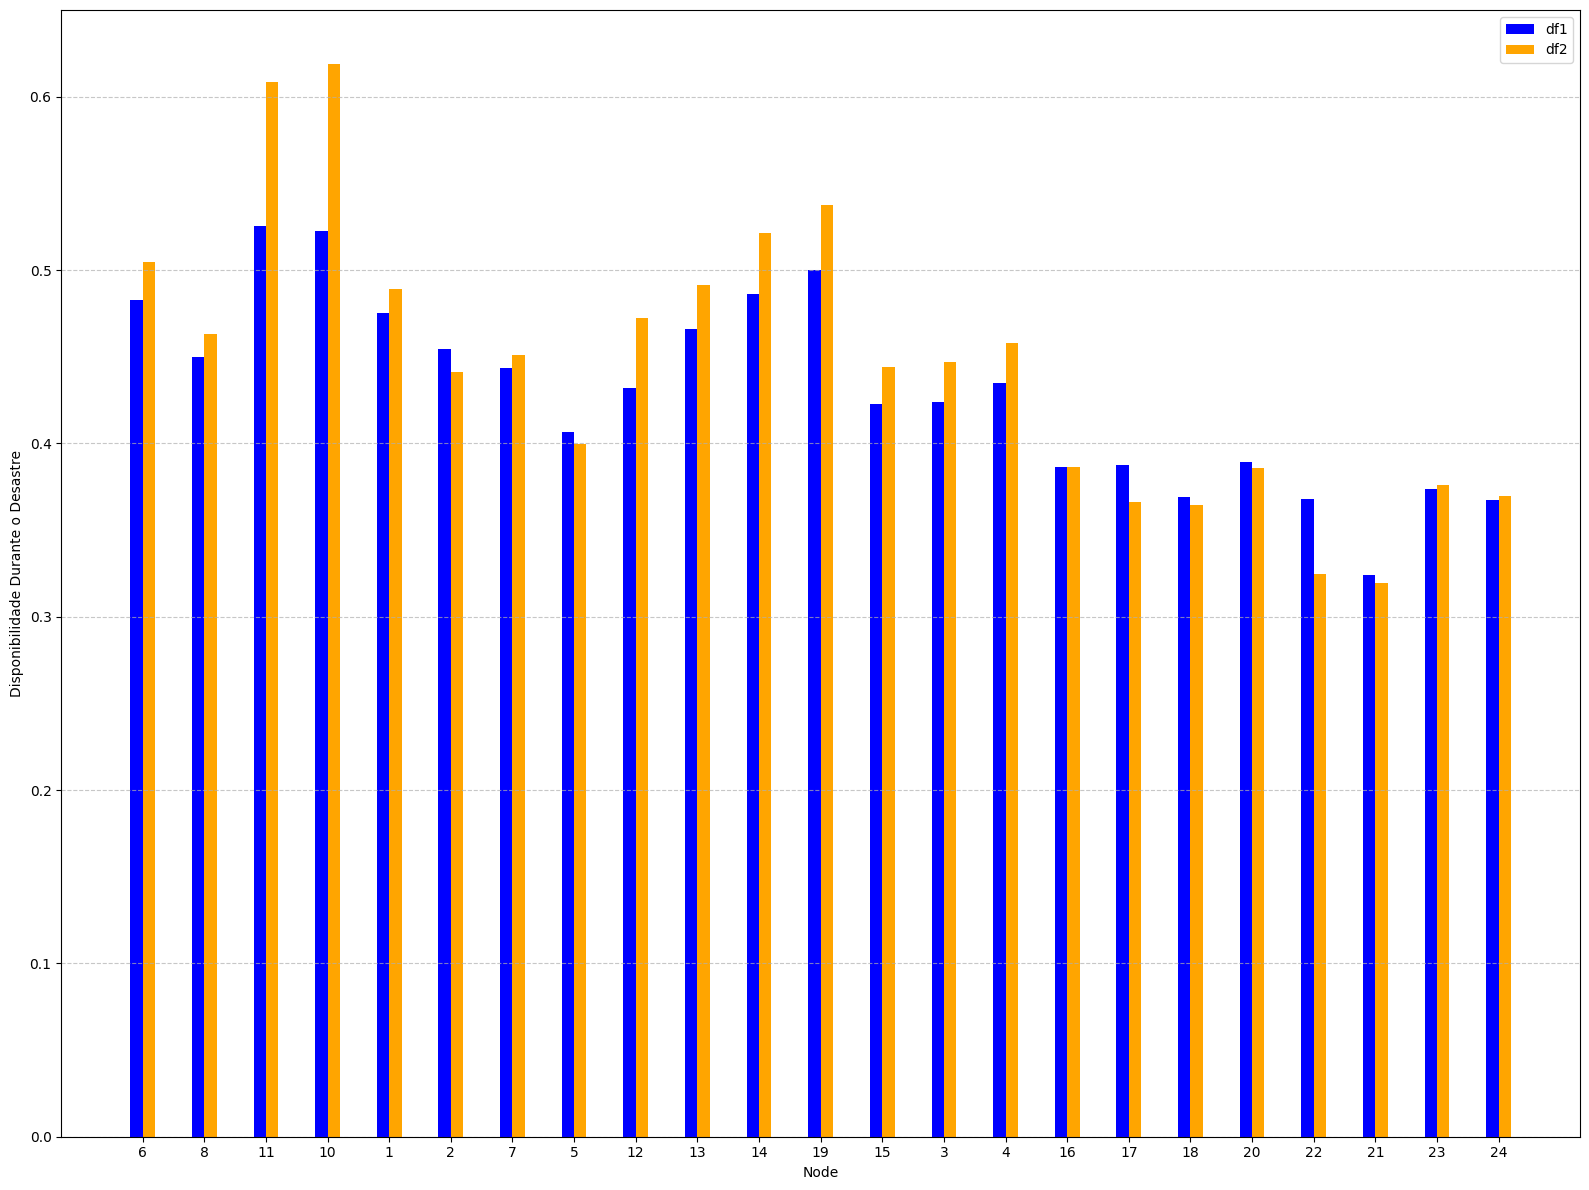

In [ ]:
plot_disponibilidade_por_nodes_bar_chart_para_dataframes()

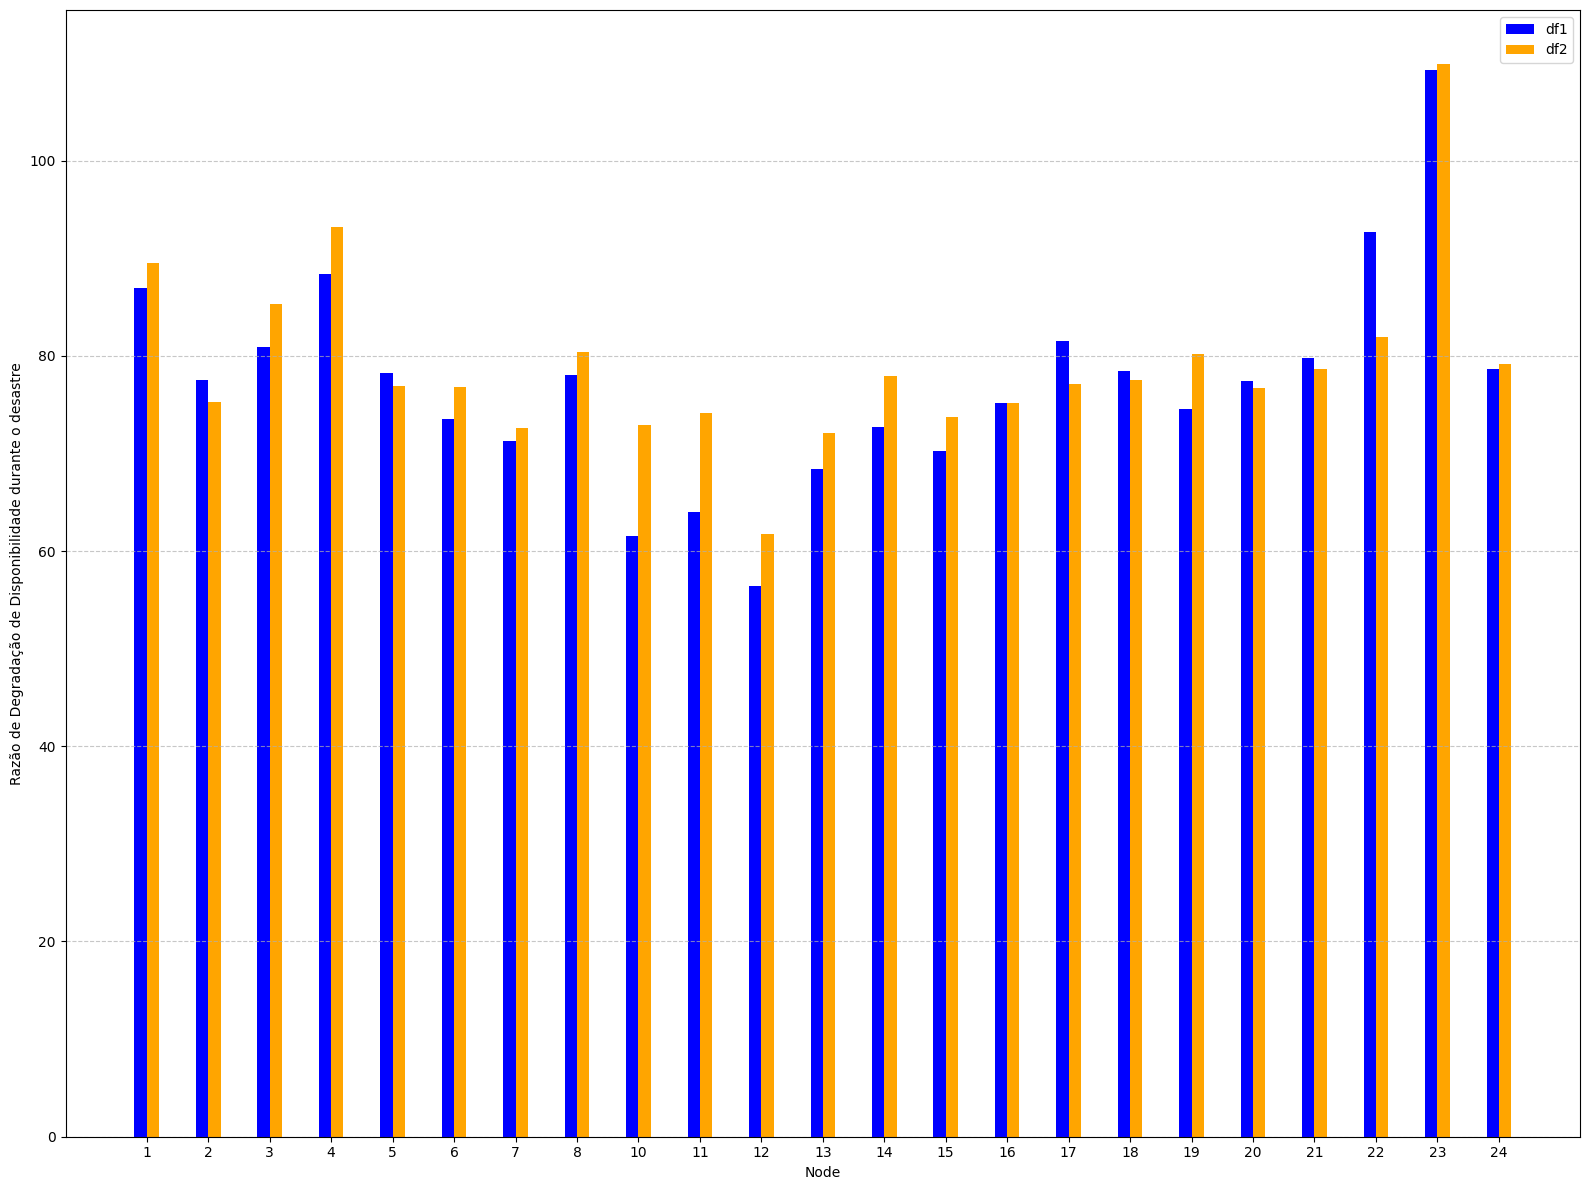

In [ ]:
plot_razao_disponibilidade_por_nodes_bar_chart_para_dataframes()

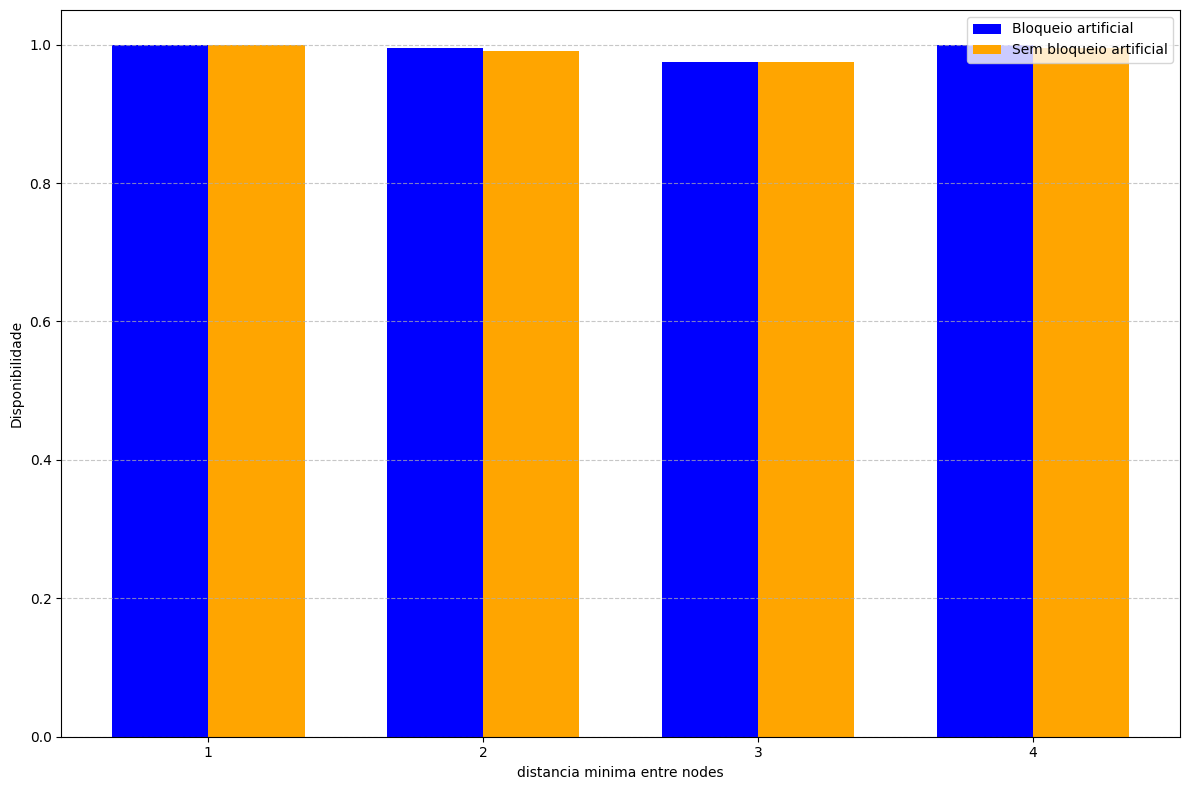

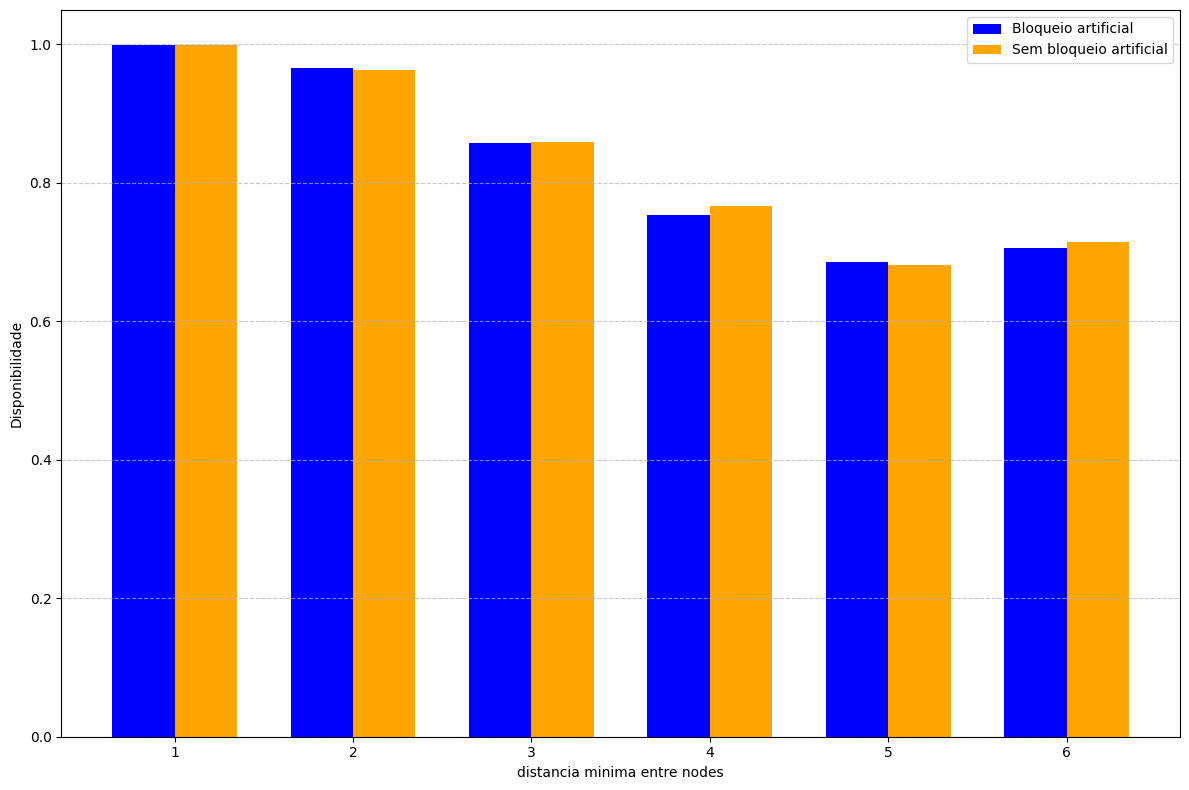

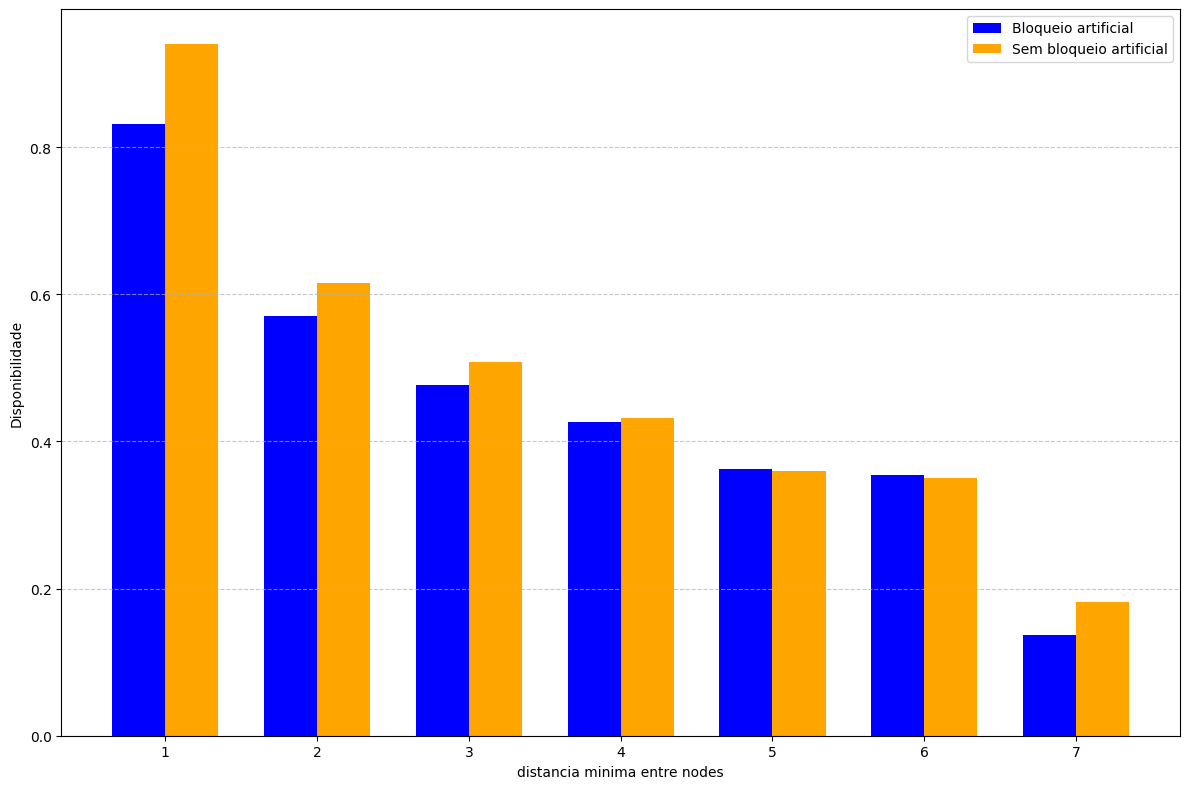

In [ ]:
plot_disponibilidade_por_distancia_minima_entre_nodes_bar_chart_para_dataframes_intra_componente1()
plot_disponibilidade_por_distancia_minima_entre_nodes_bar_chart_para_dataframes_intra_componente2()
plot_disponibilidade_por_distancia_minima_entre_nodes_bar_chart_para_dataframes_extra_componente()

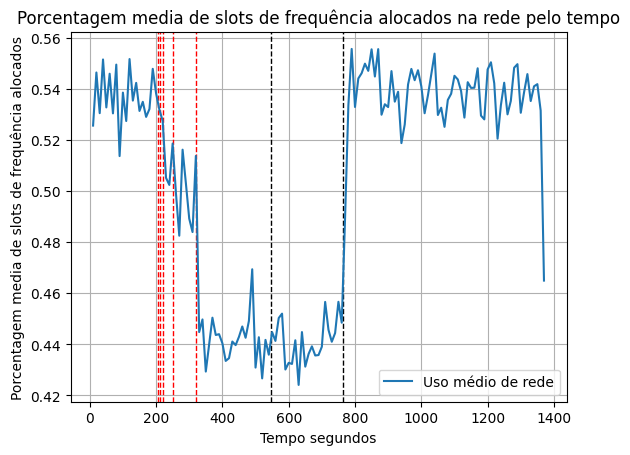

In [ ]:
plot_network_usage(dataframe1)

-0.0017159090909090887


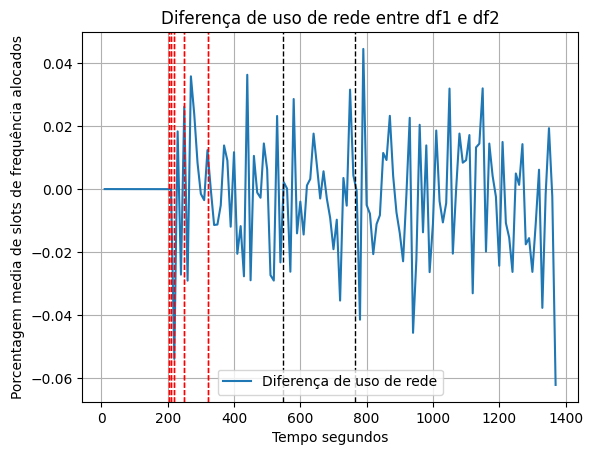

-0.0018036833855799219


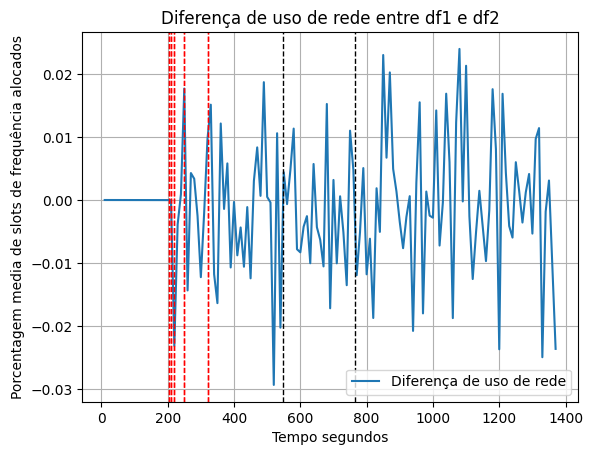

-0.024172727272727314


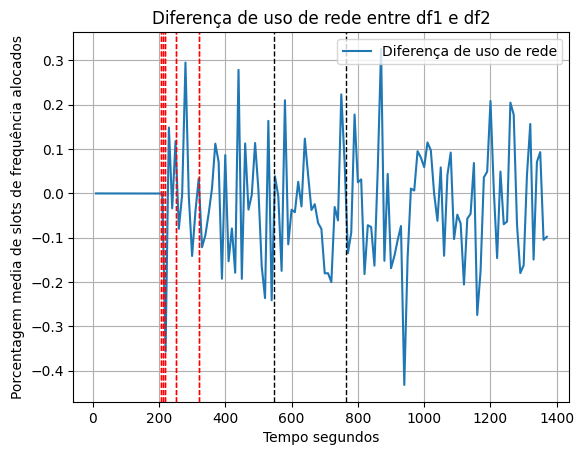

In [ ]:
links_list_intra_component1 = [
    edge
    for edge in list(TOPOLOGY.edges())
    if edge[0] in COMPONENTE_1 or edge[1] in COMPONENTE_1
]
links_list_intra_component2 = [
    edge
    for edge in list(TOPOLOGY.edges())
    if edge[0] in COMPONENTE_2 or edge[1] in COMPONENTE_2
]
links_bridge = [(8, 10), (6, 11)]
plot_network_usage_of_sub_networks(links_list_intra_component1)
plot_network_usage_of_sub_networks(links_list_intra_component2)
plot_network_usage_of_sub_networks(links_bridge)

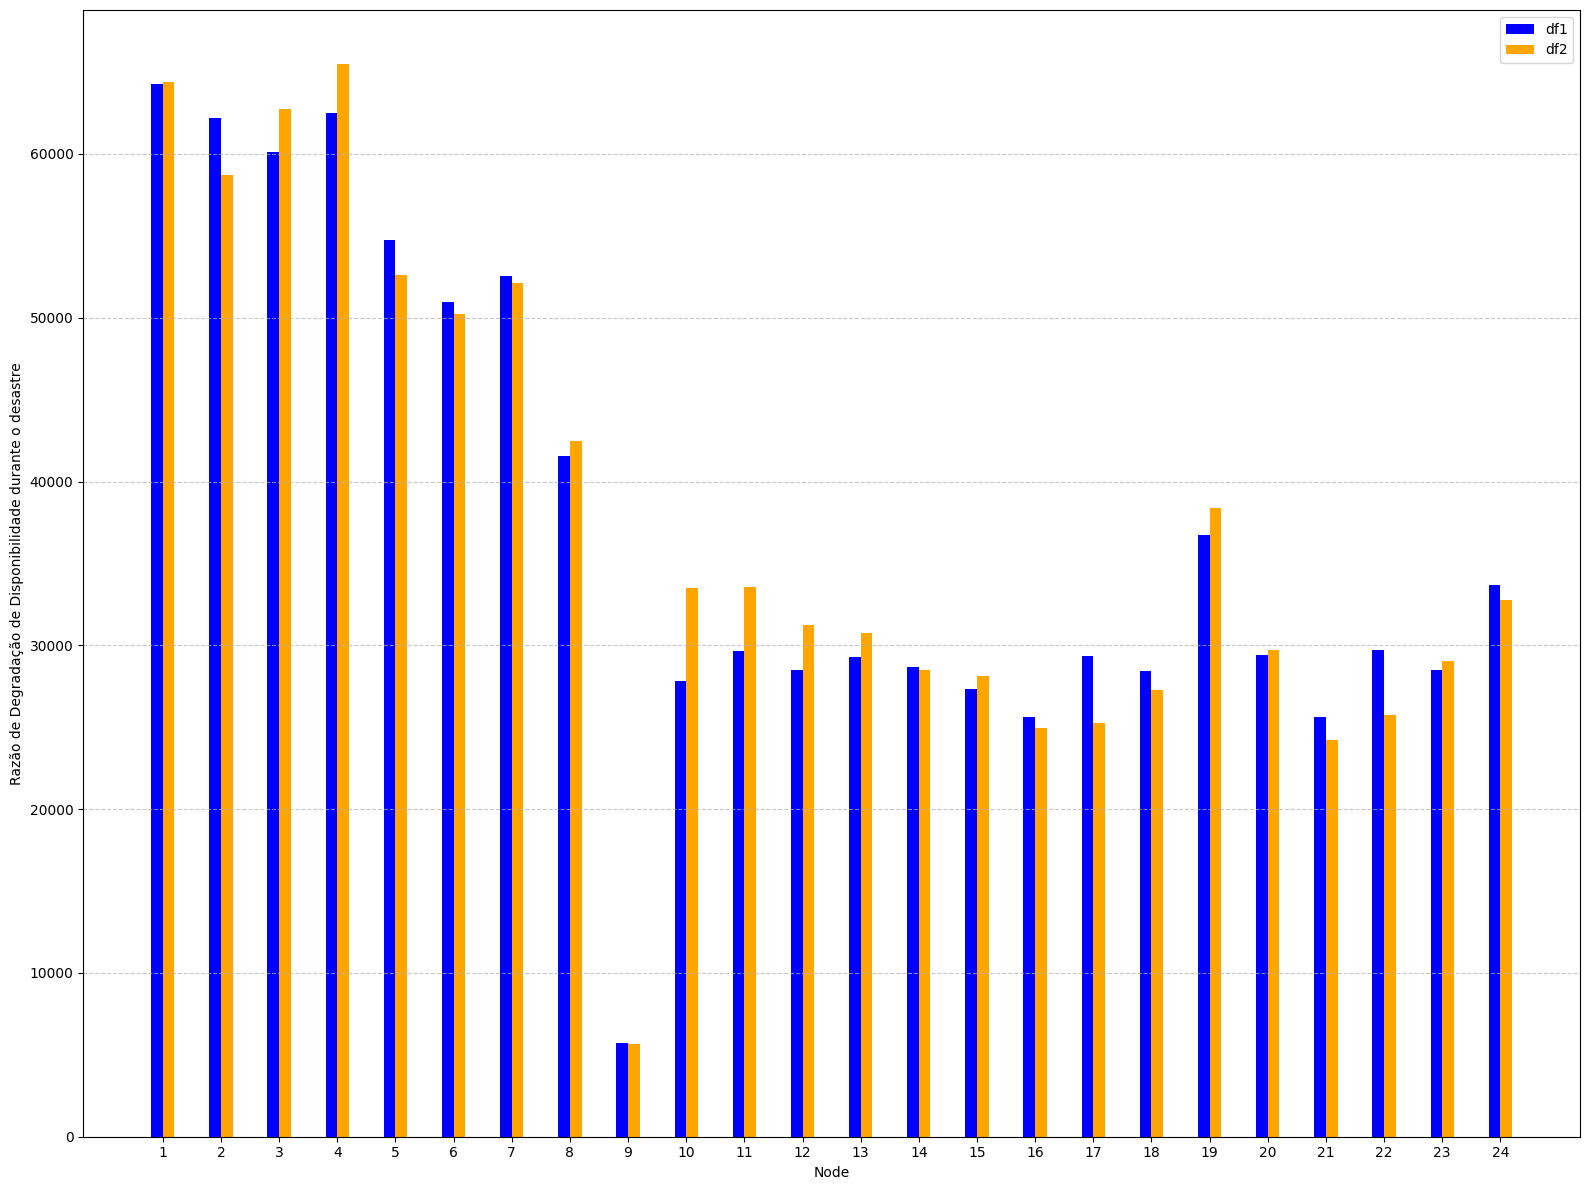

In [ ]:
plot_numero_de_slots_total_por_node_durante_desastre()

In [ ]:
numero_de_slots_dataframe1 = get_number_of_slots_alocated_during_disaster(dataframe1)
numero_de_slots_dataframe2 = get_number_of_slots_alocated_during_disaster(dataframe2)
print("numero de slots dataframe1", numero_de_slots_dataframe1)
print("numero de slots dataframe2", numero_de_slots_dataframe2)

numero de slots dataframe1 2184841.0
numero de slots dataframe2 2190804.0


Considerar fazer uma sliding window por distancia de par de nodes e considerar implementar bloqueio artificial em trafego intracomponente de maneira a facilitar alocação extra componente

analise comparativa de numero de slots alocados por node
